In [1]:
# 📦 Imports
import pandas as pd
import numpy as np

# Load data
data_path = '/kaggle/input/stress/treadmill-maximal-exercise-tests-from-the-exercise-physiology-and-human-performance-lab-of-the-university-of-malaga-1.0.1'
subject_info = pd.read_csv(f'{data_path}/subject-info.csv')
test_measure = pd.read_csv(f'{data_path}/test_measure.csv')

# Remove incomplete tests (where VO2, VE, or VCO2 is missing)
incomplete_ids = test_measure[test_measure['VO2'].isna()]['ID_test'].unique()
subject_info = subject_info[~subject_info['ID_test'].isin(incomplete_ids)]
test_measure = test_measure[~test_measure['ID_test'].isin(incomplete_ids)]

# Aggregate features per test
agg = test_measure.groupby('ID_test').agg({
    'HR': ['mean', 'max', 'std'],
    'VO2': ['mean', 'max'],
    'VCO2': ['mean'],
    'RR': ['mean'],
    'VE': ['mean'],
    'Speed': ['max'],
    'time': ['max']
})
agg.columns = ['_'.join(col) for col in agg.columns]
agg.reset_index(inplace=True)

# Merge with static subject info
merged = pd.merge(agg, subject_info, on='ID_test')

# Clean features
features = merged.drop(columns=['ID_test', 'ID'])  # Keep only numerical features


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Drop any remaining NaNs from the feature set
cleaned_features = features.dropna()

# Also drop the corresponding rows from merged so they align
merged = merged.loc[cleaned_features.index].reset_index(drop=True)
cleaned_features = cleaned_features.reset_index(drop=True)

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cleaned_features)

# KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
merged['Cluster'] = kmeans.fit_predict(X_scaled)

# Analyze cluster centers
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=cleaned_features.columns)

# Label clusters manually (can adjust based on HR_mean, VO2_mean, etc.)
center_hr = centers['HR_mean']
label_map = {center_hr.idxmax(): 'Chronic', center_hr.idxmin(): 'Normal'}
label_map[list(set([0, 1, 2]) - set(label_map.keys()))[0]] = 'Acute'

merged['Stress_Label'] = merged['Cluster'].map(label_map)
print(centers[['HR_mean', 'HR_max', 'VO2_mean', 'VO2_max', 'Speed_max', 'time_max']])


      HR_mean      HR_max     VO2_mean      VO2_max  Speed_max     time_max
0  152.289183  192.180258  2577.720859  3987.536481  17.482618  1133.530043
1  136.862843  180.187713  2212.651086  3536.747440  15.788737  1136.378840
2  150.355625  188.265625  1667.071664  2553.364583  13.982812   927.973958


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [3]:
print(centers[['HR_mean', 'HR_max', 'VO2_mean', 'VO2_max', 'Speed_max', 'time_max']])


      HR_mean      HR_max     VO2_mean      VO2_max  Speed_max     time_max
0  152.289183  192.180258  2577.720859  3987.536481  17.482618  1133.530043
1  136.862843  180.187713  2212.651086  3536.747440  15.788737  1136.378840
2  150.355625  188.265625  1667.071664  2553.364583  13.982812   927.973958


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


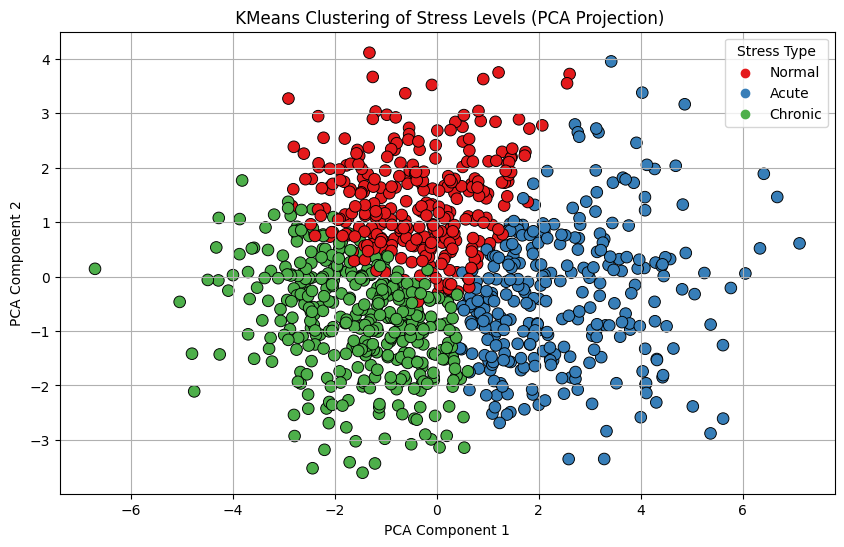

In [4]:
# 📦 Imports
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 📁 Load Data
data_path = '/kaggle/input/stress/treadmill-maximal-exercise-tests-from-the-exercise-physiology-and-human-performance-lab-of-the-university-of-malaga-1.0.1'
subject_info = pd.read_csv(f'{data_path}/subject-info.csv')
test_measure = pd.read_csv(f'{data_path}/test_measure.csv')

# 🔄 Remove tests with missing VO2/VE/VCO2 data
missing_tests = test_measure[test_measure['VO2'].isna()]['ID_test'].unique()
test_measure = test_measure[~test_measure['ID_test'].isin(missing_tests)]
subject_info = subject_info[~subject_info['ID_test'].isin(missing_tests)]

# 📊 Aggregate breath data per test
agg_test = test_measure.groupby('ID_test').agg({
    'HR': ['mean', 'max', 'std'],
    'VO2': ['mean', 'max'],
    'VCO2': ['mean'],
    'RR': ['mean'],
    'VE': ['mean'],
    'Speed': ['max'],
    'time': ['max']
})

# 🧱 Flatten column names
agg_test.columns = ['_'.join(col).strip() for col in agg_test.columns.values]
agg_test.reset_index(inplace=True)

# 🔁 Merge with subject info
merged = pd.merge(agg_test, subject_info, on='ID_test')

# ✅ Select available features dynamically
candidate_cols = ['HR_mean', 'HR_max', 'HR_std', 'VO2_mean', 'VO2_max',
                  'VCO2_mean', 'RR_mean', 'VE_mean', 'Speed_max', 'time_max',
                  'Age (years)', 'Weight (kg)', 'Height (cm)', 'Humidity (%)',
                  'Temperature (°C)', 'Sex = 1 (Female) (%)']

features = merged[[col for col in candidate_cols if col in merged.columns]]

# ✅ Drop remaining NaNs
cleaned_features = features.dropna()
merged = merged.loc[cleaned_features.index].reset_index(drop=True)
cleaned_features = cleaned_features.reset_index(drop=True)

# 🔢 Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(cleaned_features)

# 🧪 Apply KMeans Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
merged['Cluster'] = kmeans.fit_predict(X_scaled)

# 🧠 Analyze cluster centers to map labels
centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=cleaned_features.columns)
hr_means = centers['HR_mean']
vo2_means = centers['VO2_mean']

# Map cluster ID to labels based on HR and VO2 levels
label_map = {}
label_map[hr_means.idxmin()] = 'Normal'
label_map[hr_means.idxmax()] = 'Chronic'
label_map[list(set([0, 1, 2]) - set(label_map.keys()))[0]] = 'Acute'

merged['Stress_Label'] = merged['Cluster'].map(label_map)

# 📊 PCA for Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
merged['PCA1'] = X_pca[:, 0]
merged['PCA2'] = X_pca[:, 1]

# 🎨 Plotting the clusters with labels
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged, x='PCA1', y='PCA2', hue='Stress_Label', palette='Set1', s=70, edgecolor='k')
plt.title(' KMeans Clustering of Stress Levels (PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Stress Type')
plt.grid(True)
plt.show()


In [5]:
# 📊 Count of participants in each Stress Label
stress_counts = merged['Stress_Label'].value_counts()
print("📌 Stress Cluster Counts:\n")
print(stress_counts)


📌 Stress Cluster Counts:

Stress_Label
Chronic    393
Normal     298
Acute      290
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129485 (\N{STANDING PERSON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


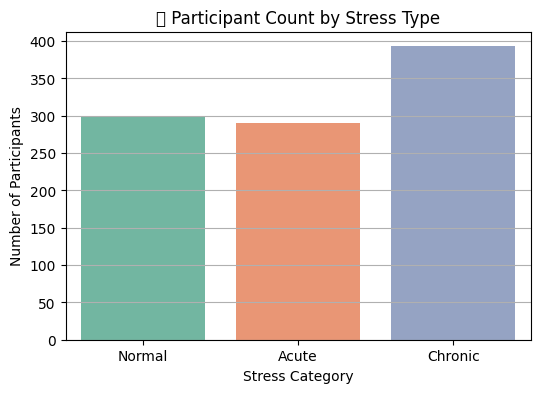

In [6]:
# Bar plot of stress category counts
plt.figure(figsize=(6, 4))
sns.countplot(data=merged, x='Stress_Label', palette='Set2')
plt.title('🧍 Participant Count by Stress Type')
plt.xlabel('Stress Category')
plt.ylabel('Number of Participants')
plt.grid(axis='y')
plt.show()

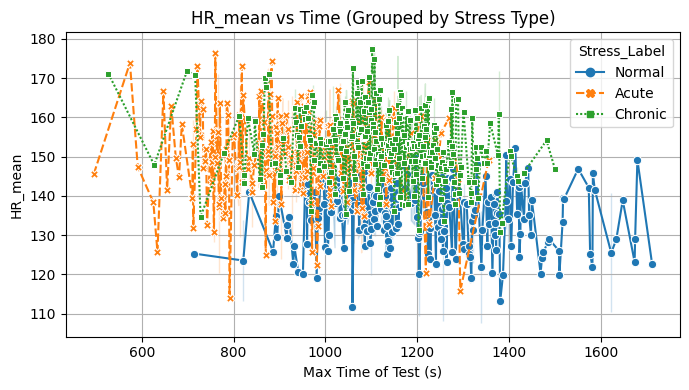

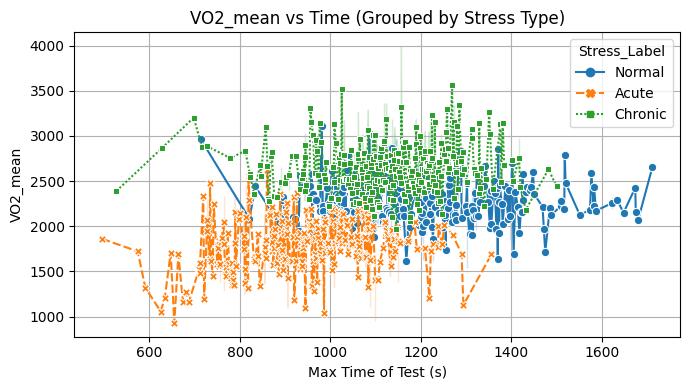

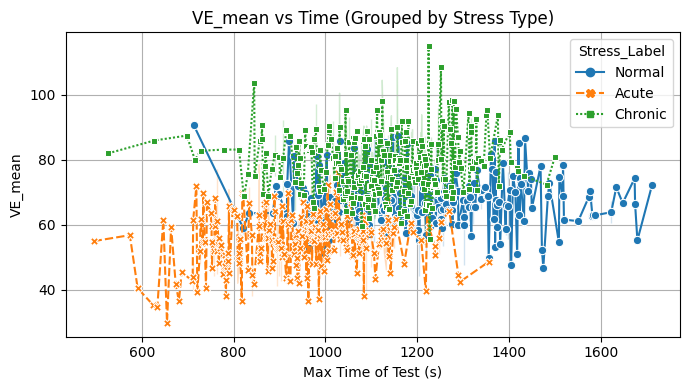

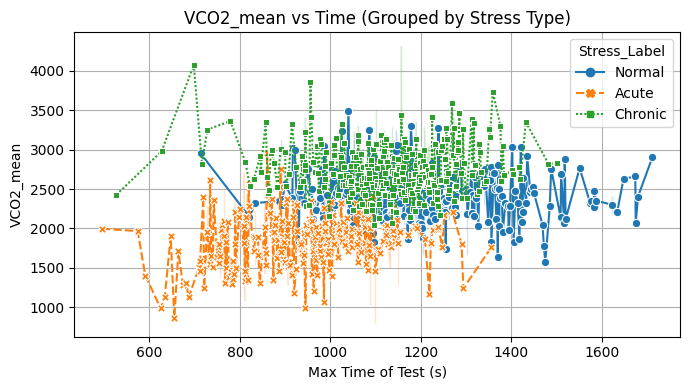

In [7]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Variables to visualize
variables = ['HR_mean', 'VO2_mean', 'VE_mean', 'VCO2_mean']  # You can add more here!

# Plot loop
for var in variables:
    plt.figure(figsize=(7, 4))
    sns.lineplot(data=merged, x='time_max', y=var, hue='Stress_Label', style='Stress_Label', markers=True)
    plt.title(f'{var} vs Time (Grouped by Stress Type)')  # Clean title without emojis
    plt.xlabel('Max Time of Test (s)')
    plt.ylabel(var)
    plt.grid(True)
    plt.tight_layout()
    plt.show()


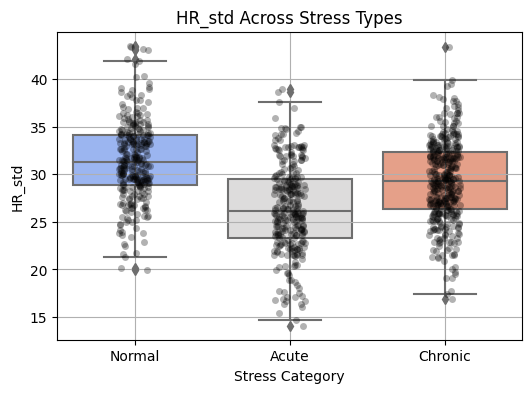

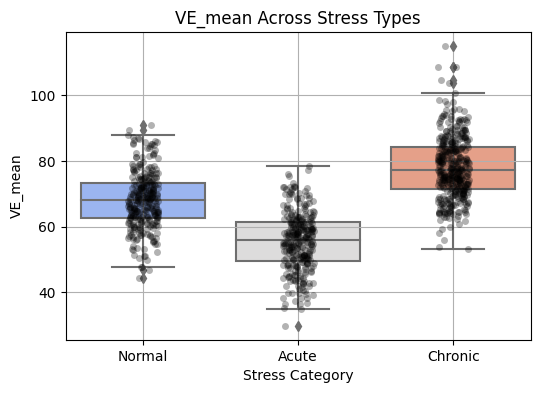

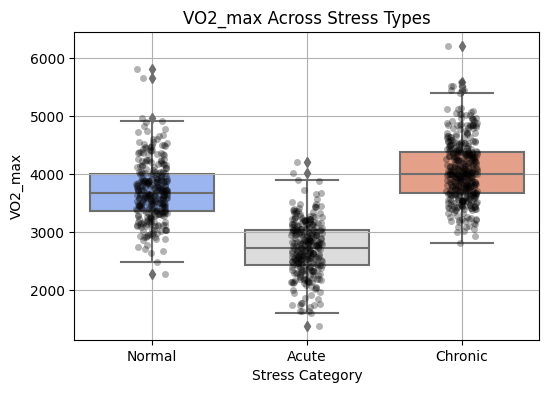

In [8]:
def plot_variable_by_stress(variable):
    """Plots the given variable across stress levels"""
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=merged, x='Stress_Label', y=variable, palette='coolwarm')
    sns.stripplot(data=merged, x='Stress_Label', y=variable, color='black', alpha=0.3, jitter=True)
    plt.title(f'{variable} Across Stress Types')
    plt.xlabel('Stress Category')
    plt.ylabel(variable)
    plt.grid(True)
    plt.show()

# 👉 Example usage:
plot_variable_by_stress('HR_std')
plot_variable_by_stress('VE_mean')
plot_variable_by_stress('VO2_max')


In [9]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Load data
test_measure = pd.read_csv(f'{data_path}/test_measure.csv')
merged_labels = merged[['ID_test', 'Stress_Label']]  # Assuming you already did clustering

# Merge stress labels into raw data
test_measure = pd.merge(test_measure, merged_labels, on='ID_test', how='inner')

# Sort data for time consistency
test_measure = test_measure.sort_values(['ID_test', 'time'])

# Normalize numerical features
scaler = StandardScaler()
features_to_scale = ['HR', 'VO2', 'VCO2', 'VE', 'RR', 'Speed']
test_measure[features_to_scale] = scaler.fit_transform(test_measure[features_to_scale])


In [10]:
def sliding_window_features(df, window_size=30, step_size=10):
    data = []
    
    for test_id, group in df.groupby('ID_test'):
        stress_label = group['Stress_Label'].iloc[0]
        group = group.reset_index(drop=True)
        total_len = len(group)
        
        for start in range(0, total_len - window_size + 1, step_size):
            window = group.iloc[start:start+window_size]
            features = {
                'ID_test': test_id,
                'Stress_Label': stress_label,
            }
            for col in features_to_scale:
                features[f'{col}_mean'] = window[col].mean()
                features[f'{col}_std'] = window[col].std()
                features[f'{col}_max'] = window[col].max()
            data.append(features)
    
    return pd.DataFrame(data)


In [11]:
window_df = sliding_window_features(test_measure, window_size=30, step_size=10)
print(window_df.head())

  ID_test Stress_Label   HR_mean    HR_std    HR_max  VO2_mean   VO2_std  \
0   100_1       Normal -1.716700  0.244363 -1.489117 -1.542017  0.247528   
1   100_1       Normal -1.615322  0.107485 -1.458083 -1.370835  0.137508   
2   100_1       Normal -1.625667  0.136521 -1.458083 -1.341526  0.091630   
3   100_1       Normal -1.626701  0.162731 -1.458083 -1.335324  0.097431   
4   100_1       Normal -1.604977  0.230650 -1.178776 -1.330723  0.084137   

    VO2_max  VCO2_mean  VCO2_std  VCO2_max   VE_mean    VE_std    VE_max  \
0 -1.247944  -1.591875  0.143458 -1.407215 -1.527814  0.138157 -1.363136   
1 -1.216250  -1.495852  0.080949 -1.407215 -1.444480  0.076321 -1.363136   
2 -1.216250  -1.473750  0.050704 -1.407215 -1.436127  0.053692 -1.363136   
3 -1.176377  -1.463288  0.060296 -1.358068 -1.438215  0.054904 -1.345236   
4 -1.176377  -1.449091  0.052354 -1.358068 -1.433144  0.047447 -1.345236   

    RR_mean    RR_std    RR_max  Speed_mean  Speed_std  Speed_max  
0 -0.842515  0.223

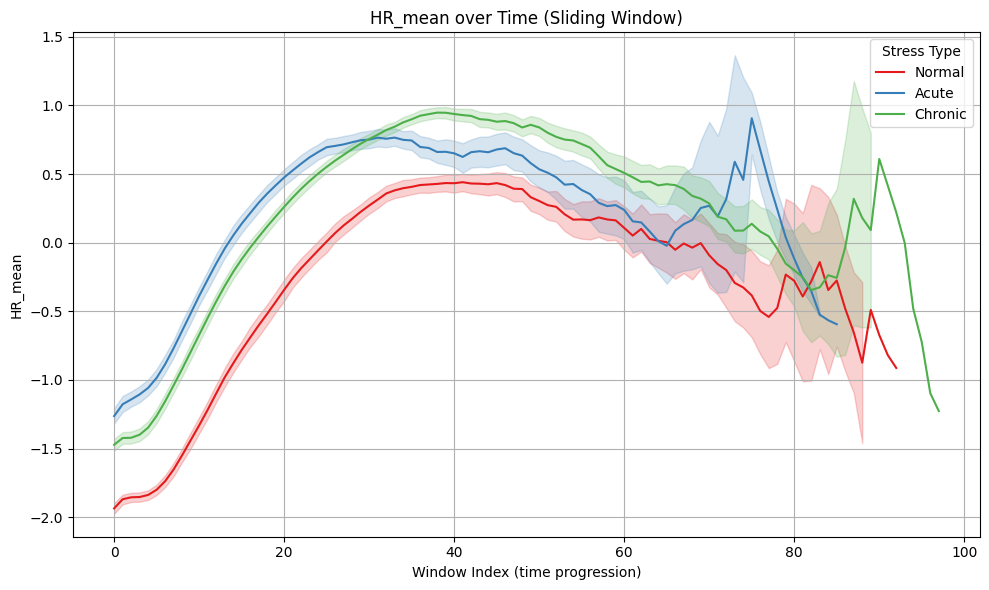

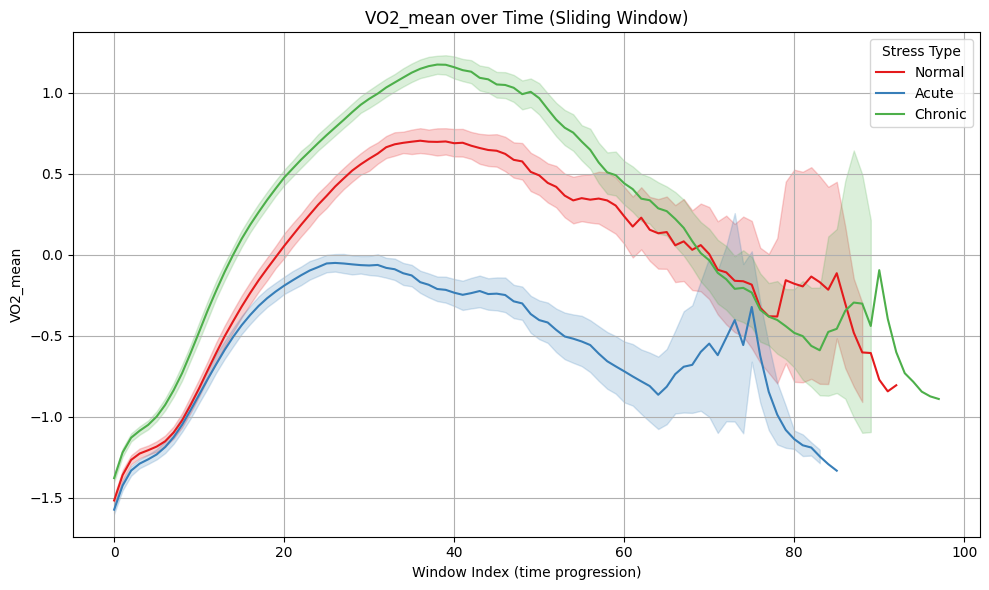

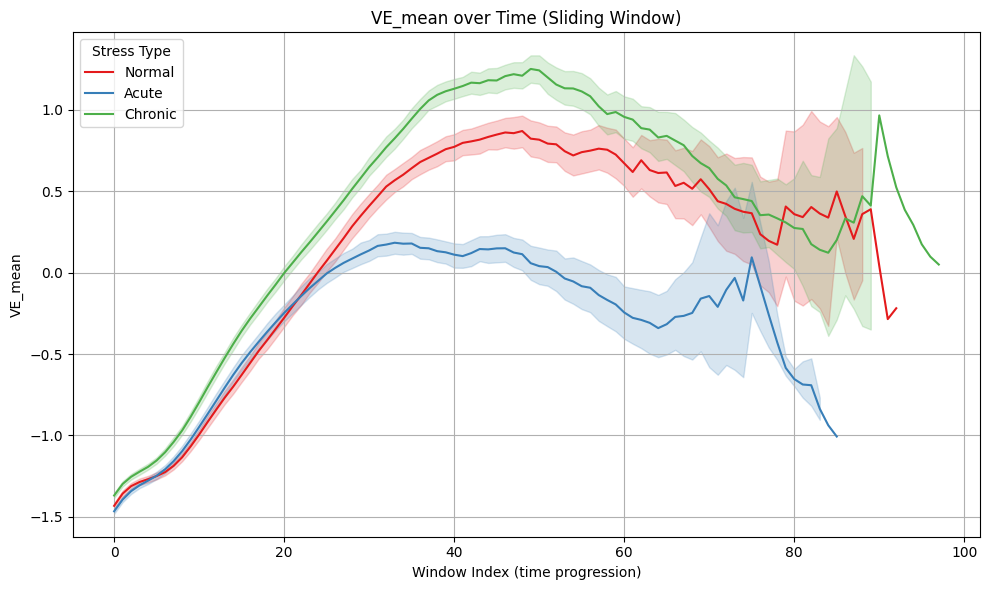

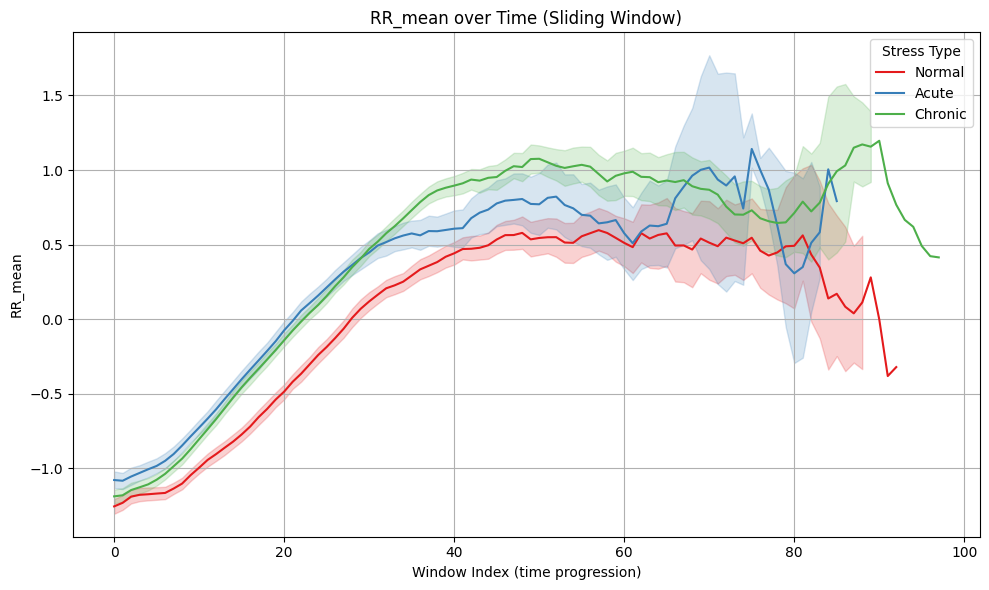

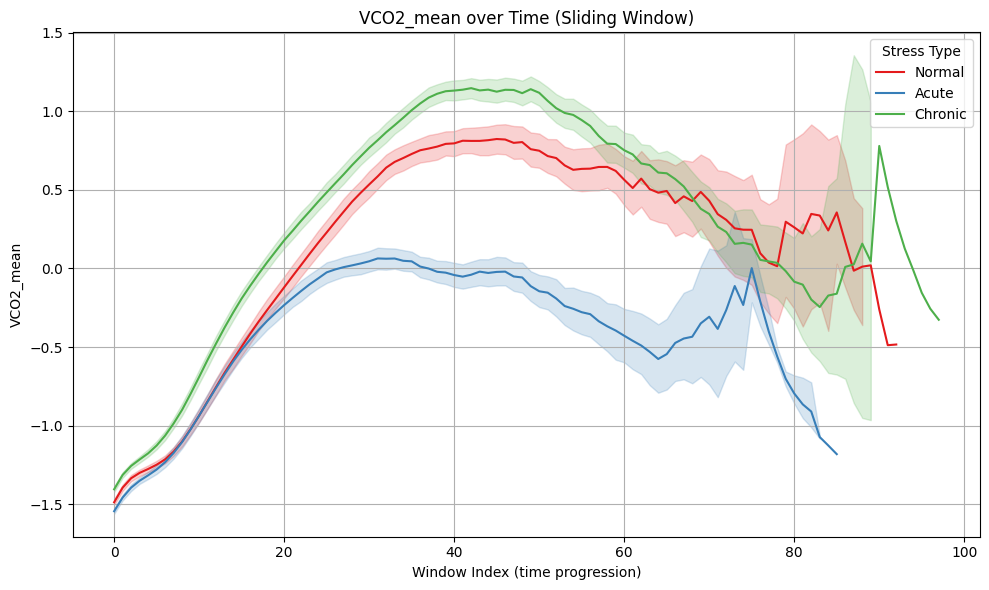

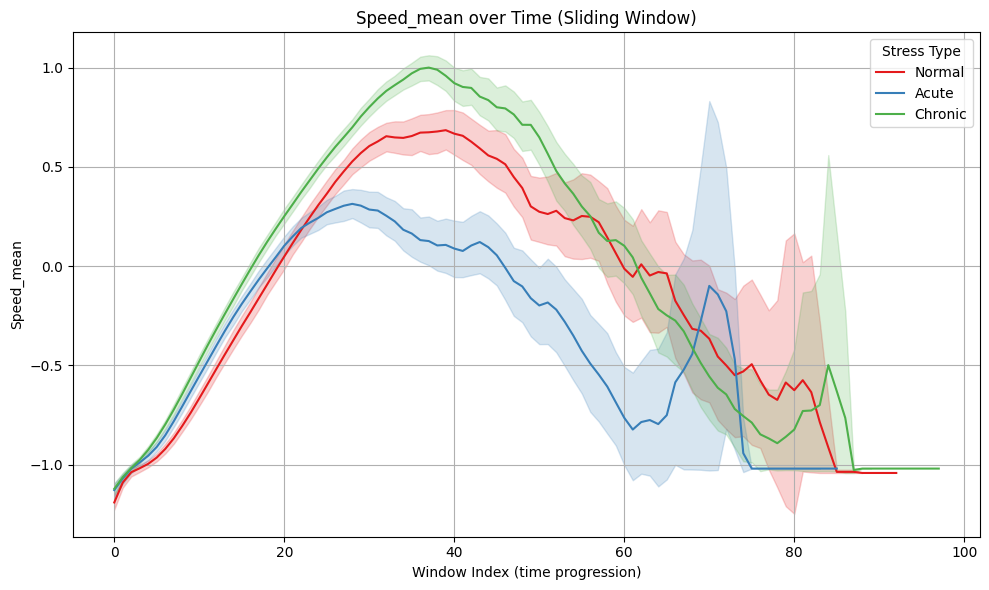

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# 📌 Choose a variable to visualize (you can loop over this later)
variables = ['HR_mean', 'VO2_mean', 'VE_mean', 'RR_mean', 'VCO2_mean', 'Speed_mean']

# 🔢 Optional: Map stress labels to ordered names for consistency
label_order = ['Normal', 'Acute', 'Chronic']
window_df['Stress_Label'] = pd.Categorical(window_df['Stress_Label'], categories=label_order, ordered=True)

# 🧮 Add a sliding "window index" per test to help track time
window_df['Window_Index'] = window_df.groupby('ID_test').cumcount()

# 🎨 Plot each variable
for var in variables:
    plt.figure(figsize=(10, 6))
    sns.lineplot(
        data=window_df,
        x='Window_Index',
        y=var,
        hue='Stress_Label',
        palette='Set1',
        estimator='mean',
        errorbar='ci'
    )
    plt.title(f'{var} over Time (Sliding Window)')
    plt.xlabel('Window Index (time progression)')
    plt.ylabel(var)
    plt.legend(title='Stress Type')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
